<a href="https://colab.research.google.com/github/keerthesh-kumar/ChestXRay_Image_Classification_Heroku_Deployment/blob/main/ChestXRay_VGG16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Mounting the drive to colab
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
# Pointing to specific folder in the drive where we have data
!ls "/content/drive/My Drive/DeepLearning/Chest_Xray"

ChestXRay  ChestXRay.ipynb  ChestXRay_VGG16.ipynb


In [ ]:
# Importing the necessary modules and packages
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Activation, Dense, Flatten, Conv2D, MaxPool2D, Dropout
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from sklearn.metrics import confusion_matrix
from keras.applications.vgg16 import VGG16

import time
import shutil
import glob
import warnings
import matplotlib.pyplot as plt
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

In [ ]:
# defining the VGG16 model
VGG16_Model = VGG16()
print(VGG16_Model.summary())

553476096/553467096 [==============================] - 4s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
____________________________________________________________

In [ ]:
# removing the last layer of the model to include only 2 classes
classifier = Sequential()
for layers in VGG16_Model.layers[:-1]:
  classifier.add(layers)

In [ ]:
print(classifier.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)       2

In [ ]:
# Freezing the layer weights so that they are not trained during fine tuning
for layer in classifier.layers:
  layer.trainable = False

In [ ]:
# Adding a final dense layer for 2 class prediction
classifier.add(Dense(2,activation='softmax'))

In [ ]:
print(classifier.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)       2

In [ ]:
# loading the image datasets and preprocessing them before loading it to the model
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   rotation_range=15,
                                   vertical_flip=True,
                                   fill_mode='reflect',
                                   data_format='channels_last',
                                   brightness_range=[0.5, 1.5],
                                   featurewise_center=True,
                                   featurewise_std_normalization=True)

val_datagen = ImageDataGenerator(rescale = 1./255)

test_datagen = ImageDataGenerator(rescale = 1./255)

training_set = train_datagen.flow_from_directory('/content/drive/MyDrive/DeepLearning/Chest_Xray/ChestXRay/train',
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 classes=['NORMAL','PNEUMONIA'])

val_set = val_datagen.flow_from_directory('/content/drive/MyDrive/DeepLearning/Chest_Xray/ChestXRay/val',
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            classes=['NORMAL','PNEUMONIA'])

test_set = test_datagen.flow_from_directory('/content/drive/MyDrive/DeepLearning/Chest_Xray/ChestXRay/test',
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            classes=['NORMAL','PNEUMONIA'])

Found 5216 images belonging to 2 classes.
Found 14 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [ ]:
# mapping the labels of the training set
label_map = (training_set.class_indices)
print(label_map)

{'NORMAL': 0, 'PNEUMONIA': 1}


In [ ]:
# Reversing the label dictionary
reversed_label_map = {value : key for (key, value) in label_map.items()}
print(reversed_label_map)

{0: 'NORMAL', 1: 'PNEUMONIA'}


In [ ]:
imgs, labels = next(training_set)

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


In [ ]:
# functions to plot the images that we stored in the folder
def plotImages(images_arr):
  fig, axes = plt.subplots(1, 10, figsize=(20,20))
  axes = axes.flatten()
  for img, ax in zip(images_arr, axes):
    ax.imshow(img)
    ax.axis('off')
  plt.tight_layout()
  plt.show()

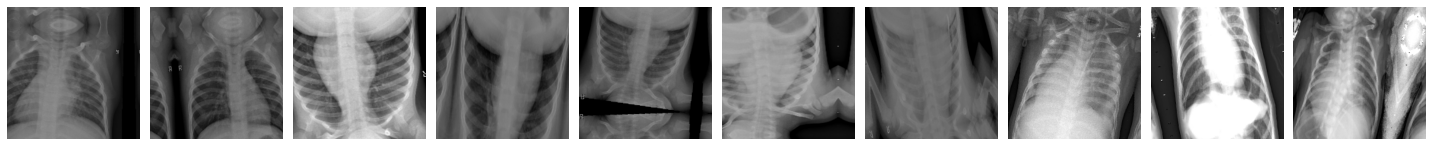

[[0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]]


In [ ]:
plotImages(imgs)
print(labels)

In [ ]:
# # Running the model using two method, using the fit method
# from keras import optimizers

# classifier.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# classifier.fit(x=training_set, validation_data=test_set, epochs=2, verbose=1)

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/2
163/163 [==============================] - 3146s 19s/step - loss: 0.5883 - accuracy: 0.7450 - val_loss: 0.5067 - val_accuracy: 0.8189
Epoch 2/2
163/163 [==============================] - 3080s 19s/step - loss: 0.4149 - accuracy: 0.8119 - val_loss: 0.4642 - val_accuracy: 0.7628


In [ ]:
# # saving the model to a h5 file for later use
# classifier.save('/content/drive/MyDrive/DeepLearning/Chest_Xray/ChestXRay/models/VGG16Model_Epoch2.h5')

### Predicting the Images

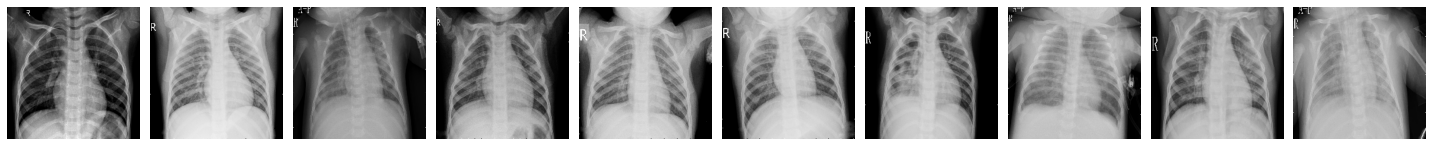

[[1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]]
(14, 224, 224, 3)


In [ ]:
val_imgs, val_lables = next(val_set)
plotImages(val_imgs)
print(val_lables)
print(val_imgs.shape)

In [ ]:
val_set.classes

array([0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

In [ ]:
# Loading the saved model into the disk
from keras.models import load_model
model = load_model('/content/drive/MyDrive/DeepLearning/Chest_Xray/ChestXRay/models/VGG16Model_Epoch2.h5')

In [ ]:
predictions = model.predict(x=val_set, verbose=0)

In [ ]:
import numpy as np
np.round(predictions)

array([[1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

### Function to predict for a single image

In [ ]:
# function to predict a single image result.
from keras.preprocessing import image
def model_predict(img_path, model):
    img = image.load_img(img_path, target_size=(224, 224))

    # Preprocessing the image
    x = image.img_to_array(img)
    x = np.true_divide(x, 255)
    x = np.expand_dims(x, axis=0)

    preds  = (model.predict(x) > 0.5).astype("int32")
    classes_names = ['NORMAL', 'PNEUMONIA']
    pred_class = classes_names[np.argmax(preds)]
    return pred_class

In [ ]:
normalPred = '/content/drive/MyDrive/DeepLearning/Chest_Xray/ChestXRay/predict_image/Normal.jpeg'
pneumoniaPred = '/content/drive/MyDrive/DeepLearning/Chest_Xray/ChestXRay/predict_image/Pneumonia.jpeg'

normalPredPath = '/content/drive/MyDrive/DeepLearning/Chest_Xray/ChestXRay/predict_image/'
pneumoniaPred = '/content/drive/MyDrive/DeepLearning/Chest_Xray/ChestXRay/predict_image/Pneumonia.jpeg'

In [ ]:
preds = model_predict(normalPred,model)
print(preds)

(224, 224, 3)
(1, 224, 224, 3)
